# Solving Travelling Salesman Problem by Genetic Algorithm

Contexts:


*   **Gene:** a city (represented as (x,y) coordinate
*   **Individual(aka chromosome):** a single route satisfying the conditions above
*   **Population:** a collection of possible routes (collection of individuals)
*   **Parents:** two routes that are combined to create a new route
*   **Mating Pool:** a collection of parents that are used to create next population (or next generation of routes)
*  **Fitness:** a function that tells us how good each route is (or how short the distance is)
*  **Mutation:** a way to introduce variation in our population by randomly swapping two cities in a route
*  **Elitism:** a way to carry best individuals into the next generation



The Genetic Algorithm wil follow the following steps:


1.   Create the population
2.   Determine fitness
3.   Select the mating pool
4. Breed
5. Mutate
6. *Repeat*



In [28]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

### Creating classes for City and Fitness

In [29]:
class City:
  def __init__(self,x,y):
    self.x,self.y = x,y
  
  def distance(self,city):
    """
      Calculating distance via Pythagoreas Theorem ( c = root[a^2 + b^2] )
    """
    xDistance, yDistance = abs(self.x - city.x), abs(self.y - city.y)
    distance = np.sqrt((xDistance **2) + (yDistance **2))
    return distance
  
  def __repr__(self):
    return f"( {str(self.x)} , {str(self.y)}"

In [30]:
class Fitness:
  def __init__(self, route):
    self.route, self.distance, self.fitness = route, 0, 0.0

  def routeDistance(self):
    if self.distance == 0:
      pathDistance = 0
      for i,v in enumerate(self.route):
        fromCity = v
        toCity = None

        if i + 1 < len(self.route):
          toCity = self.route[i + 1]
        else:
          toCity = self.route[0]

        pathDistance += fromCity.distance(toCity)

      self.distance = pathDistance
    return self.distance

  def routeFitness(self):
    if self.fitness == 0:
      self.fitness = 1 / float(self.routeDistance())
    return self.fitness

### Creating the population (aka First Generation)

In [50]:
# Route Generator
def createRoute(cityList):
  """
    creating random routes from one city to another
  """
  route = random.sample(cityList, len(cityList))
  return route

In [32]:
# Creating first population (list of routes)
def initialPopulation(populationSize, cityList):
  """
    creating routes for entire population
  """
  population = []
  for i in range(populationSize):
    population.append(createRoute(cityList))
  return population

## Creating the Genetic Algorithm

In [33]:
# ranking routes
def rankRoutes(population):
  """
    Simulating 'Survival of the fittest' by ranking each individual in the population.
    Output will be ordered list with route IDs and each associated fitness score.
  """"
  fitnessResults = {}
  for i,v in enumerate(population):
    fitnessResults[i]  = Fitness(v).routeFitness()
  return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse=True)

### Creating Next Generation (Selection of Mating Pool) by using approach of Fitness Proportionate Selection (aka Roulette Wheel Selection)

In [34]:
def selection(populationRanked, eliteSize):
  """
    Using Roulette Wheel approach to select the mating pool.
      - The fitness of each individual relative to the population is used
         to assign a probability of selection.
      - We consider this as the fitness-weighted probability of being selected.
    Another design feature to consider is the use of elitism.
      - With elitism, the best performing individuals from the population
         will automatically carry over to the next generation,
         ensuring that the most successful individuals persist.
    
    1. First we are using output from rankRoutes to determine which routes to select.
    2. Then we set up roulette wheel
    3. Then we introduce elitism to hold onto best routes
    4. Then we select the mating pool.
  """

  selectionResults = []

  # Setting up Roulette Wheel by calculation relative fitness weight of each individual
  df = pd.DataFrame(np.array(populationRanked), columns=["Index", "Fitness"])
  df["cumulative_sum"] = df.Fitness.cumsum()
  df["cumulative_percentage"] = 100 * df.cumulative_sum / df.Fitness.sum()

  # elitism
  for i in range(eliteSize):
    selectionResults.append(populationRanked[i][0])

  # selecting the mating pool
  for i in range(len(populationRanked) - eliteSize):
    pick = 100 * random.random()
    for i in range(len(populationRanked)):
      if pick <= df.iat[1,3]:
        selectionResults.append(populationRanked[i][0])
        break
  return selectionResults

### Creating Mating Pool

In [35]:
def matingPool(population, selectionResults):
  matingPool = []
  for i,v in enumerate(selectionResults):
    index = selectionResults[i]
    matingPool.append(population[index])
  return matingPool

### Creating Crossover(aka Breeding) by using approach of Ordered **Crossover**

In [36]:
def breed(parent1, parent2):
  """
    Using Ordered Crossover Breeding Approach
      - In ordered crossover, we randomly select a subset of the first parent string.
      - and then fill the remainder of the route with the genes from the second parent
      - in the order in which they appear
      - without duplicating any genes in the selected subset from the first parent
  """
  child = []
  childP1 = []
  childP2 = []

  geneA = int(random.random() * len(parent1))
  geneB = int(random.random() * len(parent1))

  startGene = min(geneA, geneB)
  endGene = max(geneA, geneB)

  for i in range(startGene, endGene):
    childP1.append(parent1[i])

  childP2 = [item for item in parent2 if item not in childP1]

  child = childP1 + childP2
  return child

### Creating a function to run the crossover over the entire mating pool

In [37]:
def breedPopulation(matingPool, eliteSize):
  children = []
  length = len(matingPool) - eliteSize
  pool = random.sample(matingPool, len(matingPool))

  for i in range(eliteSize):
    children.append(matingPool[i])

  for i in range(length):
    child = breed(pool[i], pool[len(matingPool) -i -1])
    children.append(child)

  return children

### Creating Mutation by using the approach of Swap Mutation

In [38]:
def mutate(individual, mutationRate):
  """
    Using Swap Mutation approach
      - with specified low probability, two cities will swap places in our route.
  """
  for swapped in range(len(individual)):
    if(random.random() < mutationRate):
      swapWith = int(random.random() * len(individual))

      city1, city2 = individual[swapped], individual[swapWith]

      individual[swapped], individual[swapWith] = city2, city1
  
  return individual

### Creating a function to mutate over the population

In [39]:
def mutatePopulation(population, mutationRate):
  mutatedPopulation = []

  for i,v in enumerate(population):
    mutated = mutate(v, mutationRate)
    mutatedPopulation.append(mutated)

  return mutatedPopulation

### Putting all together to create Next Generation function

In [51]:
def nextGeneration(currentGeneration, eliteSize, mutationRate):
  """
    To create the Next Generation
      1. We rank the routes in the current generation using rankRoutes.
      2. We then determine our potential parents by running the selection function.
      3. Which allows us to create the mating pool using the matingPool function.
      4. Finally, we then create our new generation using the breedPopulation function.
      5. And then applying mutation using the mutatePopulation function.
  """
  populationRanked = rankRoutes(currentGeneration)
  selectionResults = selection(populationRanked,eliteSize)
  matingpool = matingPool(currentGeneration, selectionResults)
  children = breedPopulation(matingpool, eliteSize)
  nextGeneration = mutatePopulation(children, mutationRate)
  return nextGeneration

### Putting everything together to create Genetic Algorithm

In [41]:
def geneticAlgorithm(population, populationSize, eliteSize, mutationRate, generations):
  """
    To execute the Genetic Alrothm
      1. We create the initial population.
      2. then we can loop through as many generations as we desire.

      We have printed the initial distance in start to observe how much we have improved.
  """
  current = initialPopulation(populationSize, population)
  print(f"Initial Distance: {str(1 / rankRoutes(current)[0][1])}")

  for i in range(generations):
    current = nextGeneration(current, eliteSize, mutationRate)

  print(f"Final Distance: {str(1 / rankRoutes(current)[0][1])}")
  bestRouteIndex = rankRoutes(current)[0][0]
  bestRoute = current[bestRouteIndex]
  return bestRoute

## Runnning the Genetic Algorithm

In [42]:
cityList = []
for i in range(25):
  cityList.append(
      City(
          x = int(random.random() * 200),
          y = int(random.random() * 200)
      )
  )

In [43]:
geneticAlgorithm(
    population = cityList,
    populationSize = 100,
    eliteSize = 20,
    mutationRate = 0.01,
    generations = 500
)

Initial Distance: 2020.354851174925
Final Distance: 2114.177273223884


[( 0 , 87,
 ( 94 , 141,
 ( 55 , 128,
 ( 58 , 111,
 ( 70 , 188,
 ( 136 , 132,
 ( 23 , 81,
 ( 178 , 114,
 ( 168 , 118,
 ( 138 , 9,
 ( 128 , 22,
 ( 119 , 152,
 ( 168 , 114,
 ( 162 , 145,
 ( 110 , 87,
 ( 41 , 10,
 ( 86 , 135,
 ( 160 , 26,
 ( 182 , 27,
 ( 145 , 137,
 ( 186 , 25,
 ( 188 , 13,
 ( 26 , 45,
 ( 134 , 28,
 ( 60 , 63]

##Plotting the improvement

In [44]:
def geneticAlgorithmPlot(population, populationSize, eliteSize, mutationRate, generations):
  current = initialPopulation(populationSize, population)
  progress = []
  progress.append(1 / rankRoutes(current)[0][1])

  for i in range(generations):
    current = nextGeneration(current, eliteSize, mutationRate)
    progress.append(1 / rankRoutes(current)[0][1])

  plt.plot(progress)
  plt.ylabel("Distance")
  plt.xlabel("Generation")
  plt.show()

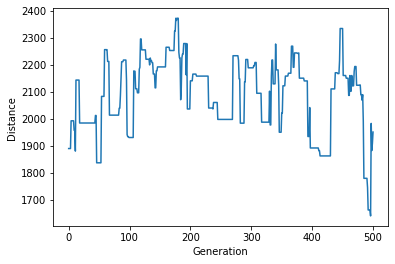

In [45]:
geneticAlgorithmPlot(
    population = cityList,
    populationSize = 100,
    eliteSize = 20,
    mutationRate = 0.01,
    generations = 500
)

Code and contributed by Shahzaib Kashif